# Libraries

In [234]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import datetime
from scipy.stats import binom 

In [235]:
def description(symbols_dict):
    descr = {}
    for symbol in symbols_dict.keys():
        descr[symbol] = []
        df = pd.DataFrame(symbols_dict[symbol])
        descr[symbol].append(df.shape)
        descr[symbol].append(df.index[1] - df.index[0])
        descr[symbol].append(df.index[0])
        descr[symbol].append(sum(df.isnull().sum()))
        descr[symbol].append(list(df.columns))
    df_descriptions = pd.DataFrame(descr, index=(['shape', 'last_date_saved', 'initial_date',
                                                        'sum_missing_values', 'columns']))
    return df_descriptions

# Load data and visualization

## Load data and general description

In [236]:
# create a symbols_dict dictionary that contains all symbols dataframes
# index_col=0: load prevention of an extra index
# parse_dates=True: load index as datetime

symbols = ['BTCUSDT', 'ETHUSDT', 'MATICUSDT', 'LINKUSDT', 'AAVEUSDT']
symbols_list = [pd.read_csv(f'{symbol}.csv',index_col=0,parse_dates=True) for symbol in symbols]
symbols_dict = dict(zip(symbols, symbols_list))
df_descriptions = description(symbols_dict)
df_descriptions

,BTCUSDT,ETHUSDT,MATICUSDT,LINKUSDT,AAVEUSDT
shape,"(1591483, 10)","(1591491, 10)","(835591, 10)","(1584900, 10)","(1588500, 10)"
last_date_saved,0 days 00:01:00,0 days 00:01:00,0 days 00:01:00,0 days 00:01:00,0 days 00:01:00
initial_date,2020-12-31 23:45:00,2020-12-31 23:45:00,2020-12-31 23:45:00,2020-12-31 12:00:00,2020-12-31 16:02:00
sum_missing_values,0,0,0,0,0
columns,"[open, high, low, close, volume, close_time, q...","[open, high, low, close, volume, close_time, q...","[open, high, low, close, volume, close_time, q...","[open, high, low, close, volume, close_time, q...","[open, high, low, close, volume, close_time, q..."


## Visualization

### Raw data visualization

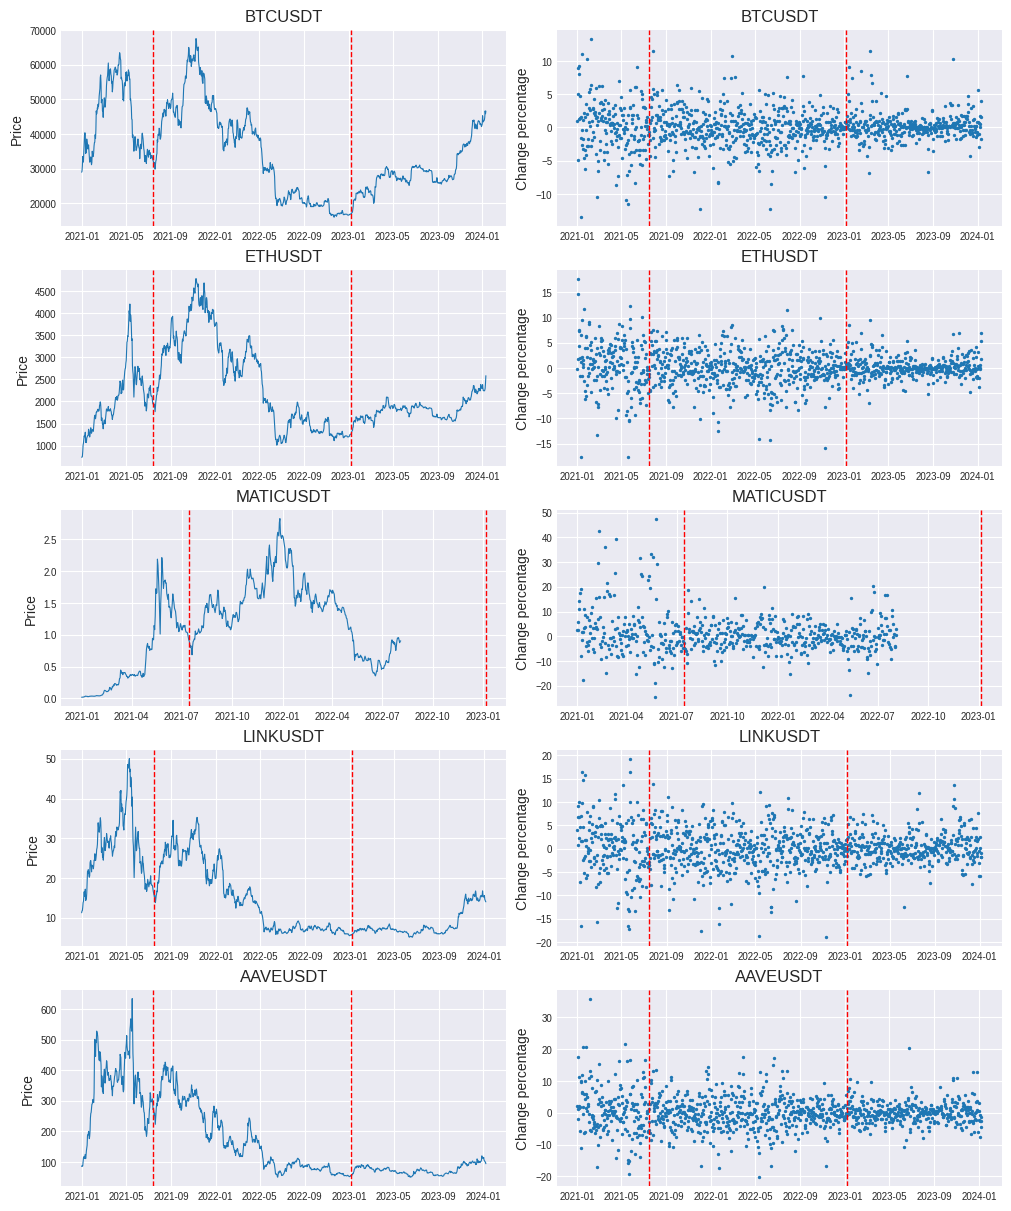

In [237]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(constrained_layout=True, figsize=(10, 12))
gs = fig.add_gridspec(5, 2)
grid1, grid2 = [], []
for row, symbol in enumerate(symbols_dict.keys()):
    data = symbols_dict[symbol]
    data = data.resample('D').mean()
    grid1.append(fig.add_subplot(gs[row, 0], title=symbol))
    grid1[row].xaxis.set_tick_params(labelsize=7)
    grid1[row].yaxis.set_tick_params(labelsize=7)
    plt.plot(data.close, lw=0.8)
    #grid1[row].grid(which='major')
    grid1[row].axvline(x = datetime.datetime(2021, 7, 15), color = 'r', linestyle = 'dashed', lw=1) 
    grid1[row].axvline(x = datetime.datetime(2023, 1, 6), color = 'r', linestyle = 'dashed', lw=1) 
    plt.ylabel('Price')    
    
    data2 = data.pct_change(1).mul(100)
    grid2.append(fig.add_subplot(gs[row, 1], title=symbol))
    grid2[row].scatter(x=data2.index, y=data2.close, s=2)
    grid2[row].axvline(x = datetime.datetime(2021, 7, 15), color = 'r', linestyle = 'dashed', lw=1) 
    grid2[row].axvline(x = datetime.datetime(2023, 1, 6), color = 'r', linestyle = 'dashed', lw=1) 
    #grid2[row].grid(which='major')
    grid2[row].xaxis.set_tick_params(labelsize=7)
    grid2[row].yaxis.set_tick_params(labelsize=7)
    plt.ylabel('Change percentage')

Características relevantes:
- **15/07/2021**: a partir de esta fecha se observan valores un menos fluctuantes que se mantienen en el tiempo de las monedas más nuevas (MATIC, LINK y AAVE). Por ello es que se va a restringir el análisis a partir de esta fecha
- **06/01/2023**: a partir de esta fecha se produce un nuevo ciclo alcista con variaciones un poco inferiores al periodo anterior
- MATIC y AAVE tienen alta variabilidad
- BTC y ETH tienen baja variabilidad

In [238]:
for symbol in symbols_dict.keys():
    symbols_dict[symbol] = symbols_dict[symbol][symbols_dict[symbol].index > '2021-07-15']

## Probabilidad de entrar en rango vs Tiempo

In [ ]:
pairs = {}
pairs_selected = ['BTC/ETH', 'BTC/MATIC', 'BTC/AAVE', 'BTC/LINK', 'ETH/MATIC', 
                  'LINK/MATIC', 'AAVE/MATIC', 'ETH/LINK', 'AAVE/LINK', 'ETH/AAVE']
for symbol1 in symbols:
    for symbol2 in symbols:
        pair = symbol1.split('USDT')[0]+'/'+symbol2.split('USDT')[0]
    
        if pair in pairs_selected:
            pairs[pair] = symbols_dict[symbol1] / symbols_dict[symbol2]

In [ ]:
for threshold in np.linspace(0.1, 0.01, 10):
    print(round(threshold, 2))

In [ ]:
# print(plt.style.available)
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
pairs_probability = {}
for i, pair in enumerate(pairs.keys()):
    for threshold in np.linspace(0.1, 0.01, 10):
        threshold = round(threshold, 2)
        row, col = i//2, i%2 
        data = pairs[pair].pct_change(1).mul(100).close
        data = data
        n = len(data)
        x = np.linspace(1, 240, 240)
        for count, tick in enumerate(x):
            p = len(data[data >= threshold])/len(data)
            data = data.resample(f'{tick}T').sum()
            if count == 0:
                pairs_probability[f'{pair}_{threshold}'] = [p]
            else:
                pairs_probability[f'{pair}_{threshold}'].append(p)
        ax[row, col].plot(x, pairs_probability[f'{pair}_{threshold}'], lw=1)
    ax[row, col].xaxis.set_tick_params(labelsize=7)
    ax[row, col].yaxis.set_tick_params(labelsize=8)
    ax[row, col].set_xlim(1, 30)
    ax[row, col].set_ylim(0, 0.5)
    ax[row, col].set_yticks(np.linspace(0, 0.5, 11))
    ax[row, col].set_xticks(np.linspace(1, 30, 30))
    ax[row, col].set_ylabel('Probability')  
    ax[row, col].set_xlabel('Time (min)', fontsize=8, loc='right')
    ax[row, col].legend(np.linspace(0.1, 0.01, 10).round(2), fontsize=5)
    ax[row, col].set_title(pair)

In [ ]:
pairs_probability['BTC/ETH_0.05'][2]

- Las curvas se aproximan al 50% a medida que pasa el tiempo. Esto es lógico si se tiene en cuenta que la distribución es aproximadamente normal con una media igual a 0
- Las curvas se aplanan llegando a valores cercanos a los máximos aproximadamente a los 3 minutos. Este es un parámetro importante a tener en cuenta a la hora de la actualización del pool. Séria bueno actualizar el pool luego de 5 minutos si éste no ha alcanzado el rango

### Distribución binomial teniendo en cuenta una duración de 3 minutos de pools fallidos

In [ ]:
# setting the values 
# of n and p 
df_prob_acum = pd.DataFrame({})
for pair in pairs_probability.keys():   
    n = 10
    p = pairs_probability[f'{pair}'][2] # one trial probability at minute 3
    # defining the list of r values 
    r_values = list(range(n + 1)) 
    # obtaining the mean and variance  
    mean, var = binom.stats(n, p) 
    # list of pmf values 
    dist = [binom.pmf(r, n, p) for r in r_values] 
    cum_prob = round(sum(dist[1:]), 3)
    """
    color = ['darkblue', 'darkred', 'darkred', 'darkred', 'darkred', 'darkred']
    plt.bar(r_values, dist, color=color)
    plt.annotate(f'Probabilidad acumulada: {cum_prob}', (4.3, 0.3), 
                 ha='center', va='center', size=10, color='darkred')
    plt.title(pair)
    plt.show()
    """
    dist = [*dist, cum_prob]
    df_prob_acum[pair] = dist
df_prob_acum = df_prob_acum.round(3)
df_prob_acum.index = [*[i for i in range(n+1)], 'éxitos >= 1']

In [ ]:
plt.style.use('seaborn-notebook')
sample = data.sample(frac=0.1)
plt.hist(sample)
#sns.displot(data=sample, x='close')
std_list = []
for i in [-3, -2, -1, 1, 2, 3]:
    std = sample.std()*i
    plt.axvline(x=std , color='r', linestyle='dashed', lw=0.5)
    std_list.append(std)
xticks= plt.xticks(np.linspace(-20, 20, 17), rotation=90)

In [184]:
df3 = df.resample('720T').max().pct_change(1).mul(100)

(0.0, 162.75)

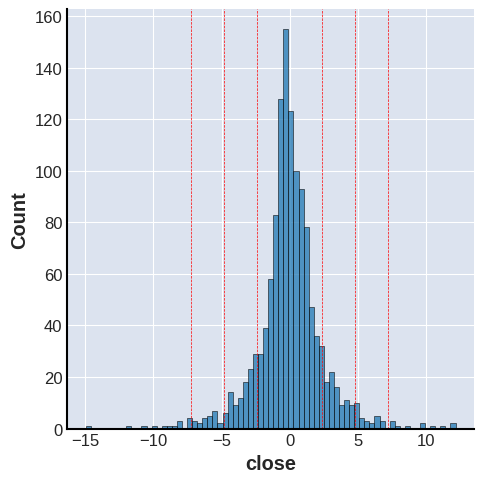

In [185]:
sns.displot(data=df3, x='close')
for i in [-3, -2, -1, 1, 2, 3]:
    plt.axvline(x = df3.close.std()*i, color = 'r', linestyle = 'dashed', lw=0.5) 
plt.ylim()

<AxesSubplot:xlabel='time'>

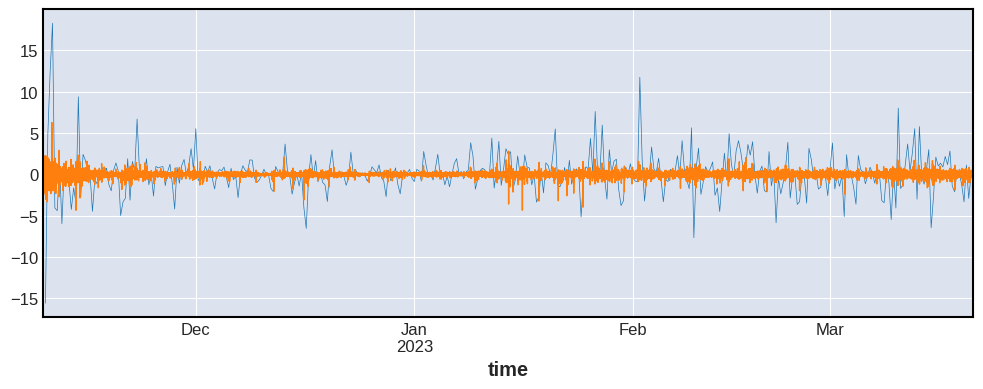

In [13]:
plt.figure(figsize=(12, 4))
df.resample('8H').min().close.pct_change(1).mul(100).plot(lw=0.5)
df.resample('5T').min().close.pct_change(1).mul(100).plot(lw=1)

<AxesSubplot:xlabel='time'>

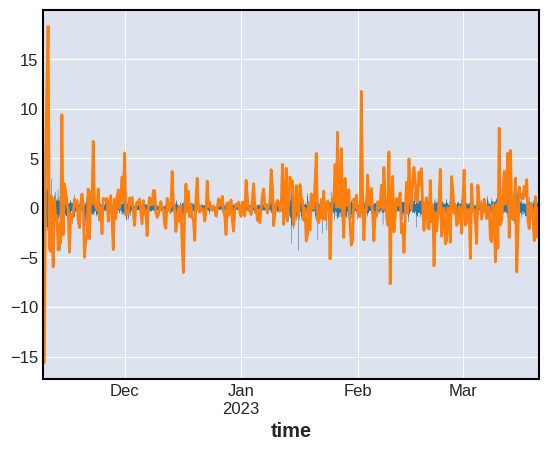

In [18]:
df2 = df[df.index > '2023-10-01']
df.resample('5T').min().close.pct_change(1).mul(100).plot(lw=0.2)
df.resample('8H').min().close.pct_change(1).mul(100).plot(lw=2)

-1.3154907375470692
-0.8769938250313795
-0.43849691251568973
0.43849691251568973
0.8769938250313795
1.3154907375470692


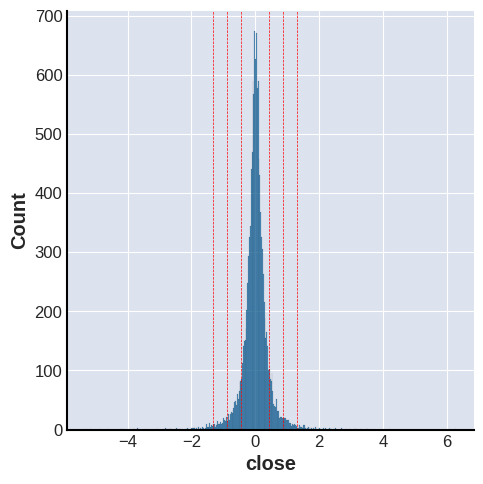

In [57]:
df_15m = df.resample('15T').min().pct_change(1).mul(100)
sns.displot(data=df_15m, x='close')
for i in [-3, -2, -1, 1, 2, 3]:
    plt.axvline(x = df_15m.close.std()*i, color = 'r', linestyle = 'dashed', lw=0.5) 
    print(df_15m.close.std()*i)

In [204]:
e = df.pct_change(1).mul(100).resample('5T').sum()
e.head(3)

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
time,,,,,,,,,,
2021-11-05 16:25:00,-0.061774,-0.072049,-0.039727,-0.078294,63.133656,0.000015,63.055267,25.150204,104.097669,104.017839
2021-11-05 16:30:00,0.042060,0.043520,0.050048,0.057240,73.679195,0.000018,73.715110,-5.068199,230.298812,230.354040
2021-11-05 16:35:00,-0.086466,-0.083003,-0.100837,-0.110813,96.862537,0.000018,96.739933,46.333463,153.959266,153.757927


In [209]:
len(e[e.close < -0.1])/len(e)*100

22.553960566333412

buen articulo para ver las distribuciones

https://medium.com/@sigari.salman/discovering-the-best-fit-probability-distribution-for-your-data-a14c0e8d762

<AxesSubplot:xlabel='time', ylabel='close'>

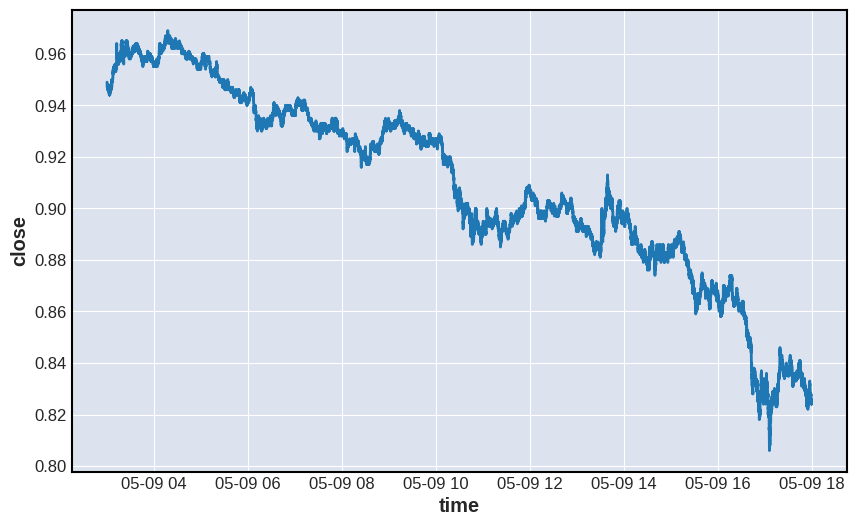

In [459]:
symbol = 'MATICUSDT_20220511_1s'
df = pd.read_csv(f'{symbol}.csv', index_col=0, parse_dates=True)
df = df[df.index < '2022-05-9 18:00:00']
plt.figure(figsize=(10, 6))
sns.lineplot(data=df.close)

In [460]:
df

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
time,,,,,,,,,,
2022-05-09 03:00:00,0.949,0.949,0.949,0.949,0.0,1652065200999,0.0000,0,0.0,0.0000
2022-05-09 03:00:01,0.949,0.949,0.948,0.949,25414.0,1652065201999,24117.4785,37,21360.9,20271.4941
2022-05-09 03:00:02,0.949,0.949,0.949,0.949,0.0,1652065202999,0.0000,0,0.0,0.0000
2022-05-09 03:00:03,0.948,0.948,0.948,0.948,1151.9,1652065203999,1092.0012,4,0.0,0.0000
2022-05-09 03:00:04,0.948,0.948,0.948,0.948,0.0,1652065204999,0.0000,0,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...
2022-05-09 17:59:55,0.825,0.825,0.825,0.825,0.0,1652119195999,0.0000,0,0.0,0.0000
2022-05-09 17:59:56,0.825,0.825,0.825,0.825,1683.9,1652119196999,1389.2175,7,1683.9,1389.2175
2022-05-09 17:59:57,0.824,0.824,0.824,0.824,44.8,1652119197999,36.9152,1,0.0,0.0000


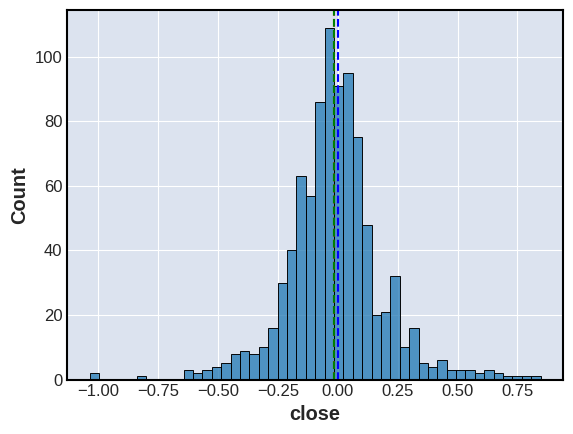

In [461]:
df = df.resample('1T').sum().pct_change(1).mul(100)
sns.histplot(data=df.close)
plt.axvline(x = 0, color = 'b', linestyle = 'dashed', lw=1.5) 
plt.axvline(x = df.close.mean(), color = 'r', linestyle = 'dashed', lw=1.5) 
plt.axvline(x = df.close.median(), color = 'g', linestyle = 'dashed', lw=1.5) 

<AxesSubplot:xlabel='time', ylabel='close'>

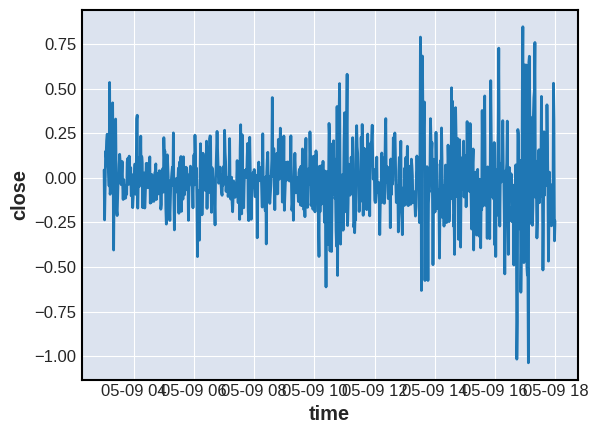

In [462]:
sns.lineplot(data=df.close)

In [465]:
len(df.close[df.close < 0])/len(df.close)

0.5544444444444444

In [464]:
df.close.sum()

-13.519000937578463

In [454]:
df

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
time,,,,,,,,,,
2022-05-09 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-09 03:00:30,-0.014076,-0.014076,-0.014077,-0.017595,-80.433414,0.000002,-80.467047,-62.711864,-72.928139,-72.984240
2022-05-09 03:01:00,0.070390,0.070390,0.073912,0.073912,734.923304,0.000002,734.946057,81.818182,-6.734471,-6.708549
2022-05-09 03:01:30,-0.042204,-0.042204,-0.042204,-0.042204,-77.512595,0.000002,-77.510179,-50.000000,-36.435408,-36.424120
2022-05-09 03:02:00,-0.158334,-0.158334,-0.158334,-0.158334,326.329749,0.000002,325.818653,220.000000,253.489295,253.315890
...,...,...,...,...,...,...,...,...,...,...
2022-05-09 17:57:30,0.176686,0.176664,0.188770,0.188747,-75.963763,0.000002,-75.946048,-64.062500,-93.634908,-93.618519
2022-05-09 17:58:00,-0.356756,-0.360721,-0.360794,-0.368767,122.363133,0.000002,121.515888,91.304348,266.387188,264.543637
2022-05-09 17:58:30,-0.160914,-0.152856,-0.164957,-0.156904,25.926713,0.000002,25.803879,31.818182,34.642086,34.563374


In [504]:
df_btc = pd.read_csv('BTCUSDT.csv', index_col=0, parse_dates=True)
df_eth = pd.read_csv('ETHUSDT.csv', index_col=0, parse_dates=True)
df2 = df_btc - df_eth
df2 = df2[(df2.index > '2023-07-01 00:00:00') & (df2.index < '2023-07-01 00:59:59')]
df2 = df2.pct_change(1).mul(100)

<AxesSubplot:xlabel='time', ylabel='close'>

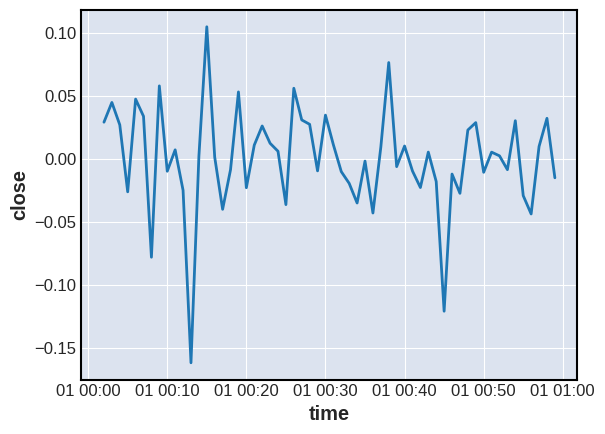

In [505]:
sns.lineplot(data=df2.close)

In [506]:
df2

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
time,,,,,,,,,,
2023-07-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-01 00:02:00,-0.064632,0.006025,0.011464,0.029515,-53.908606,NaN,51.776914,32.831325,-30.839052,741.872186
2023-07-01 00:03:00,0.029585,0.013381,0.029515,0.045206,-11.044023,NaN,-39.238564,4.535147,-78.869741,9.635835
2023-07-01 00:04:00,0.045206,0.022416,0.045206,0.027392,300.638022,NaN,-114.529660,-61.605206,1853.434294,-132.636116
2023-07-01 00:05:00,0.027392,-0.004307,-0.015973,-0.025773,-53.636803,NaN,-482.037255,112.994350,-91.840201,-204.616719
2023-07-01 00:06:00,-0.025843,0.022026,0.017587,0.047847,96.245538,NaN,-112.363810,-49.602122,1115.459965,-156.473589
2023-07-01 00:07:00,0.047917,0.034275,0.049423,0.034205,-21.886581,NaN,-740.360625,46.315789,-73.442882,-284.462241
2023-07-01 00:08:00,0.034205,-0.000070,-0.045093,-0.077696,-70.453644,NaN,118.446512,5.395683,-87.743119,-75.053279
2023-07-01 00:09:00,-0.077731,-0.019424,0.000000,0.058353,253.486022,NaN,-85.195732,-32.764505,1650.375975,202.472663
